# A Deep Knowledge Tracing (DKT) approach to Dynamic Student Modelling

Variants of this work has been published here: https://dl.acm.org/doi/10.1145/3375462.3375479

In [2]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

import pydotplus 
import graphviz

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Masking,Dense,Dropout,Embedding,Flatten,Add,Input,Concatenate
from tensorflow.keras.layers import TimeDistributed,RepeatVector,LSTM,GlobalAveragePooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras import backend as K

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler

from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_score, precision_recall_curve
from sklearn.metrics import brier_score_loss, accuracy_score, recall_score, f1_score

import gc
import math
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from operator import itemgetter 

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

sns.set(rc={'figure.figsize':(9,6),'lines.linewidth': 5, 'lines.markersize': 10})
plt.style.use('seaborn-whitegrid')
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid",{"font.family": ["Corbel"]})

random.seed(1) 
tf.random.set_seed(1)

SRL_ROOT_DOC = 'D:/DPhil - University of Oxford/Reports/SRL/'
DATA_ROOT_DOC = 'D:/DPhil - University of Oxford/Reports/ELO/'
MODEL_ROOT_DOC = 'D:/Statistical Programming Projects/Knowledge Tracing/DKT/'

# Auto-Encoding DKT for LIFE project (http://www.oxlifeproject.org)

For the DKT model proposed, autoencoding was implemented in the hidden layers. Autoencoders are neural networks that use unsupervised learning technique for the task of representation learning. A DKT autoencoder model would seek to learn a compressed knowledge representation from learners’ trajectories of learning task attempts. This is useful because when it creates a bottleneck in the neural network (i.e. undercomplete), it forces the model to learn the most salient features of the original input features (student performance data). To avoid the model behaving like an identity function which duplicates the input features to the output features, regularisation is employed to force the DKT model to respond to unique statistical features of the input features. Additionally, use of a loss function may be employed to encourage the model to have other properties besides the ability to replicate features i.e. insensitive to memorising input features but sensitive enough to build a reconstruction of data. Essentially, this usage of autoencoding achieves data denoising and dimensionality reduction.  If it was a linear network, (i.e. with no hidden layers, which have non-linear activation functions), the dimensionality reduction would be equivalent to Principal Components Analysis (PCA). 
 
Using a DKT autoencoder is technically applying self-supervised model learning methods to student learning data to represent their knowledge. The best performing DKT model is posited to be a composite model that combines autoencoding of knowledge representation as continuous and high-dimensional together with prediction of students future performance (Srivastava et al., 2015, Sapountzi A. et al., 2018).

Arguably, LSTMs mimicking of memory better supports knowledge tracing by accounting for learning ‘history’, based on the recency and outcome of completed learning tasks. This can be done to ensure that the conjunctive nature of the learning content are factored into the prediction of student's future performance. 

In [3]:
life_play_data = pd.read_csv(DATA_ROOT_DOC+'life_play_data.csv')
life_play_data.loc[life_play_data.Correct==1,['Feedback']] = -1
life_play_data.Feedback = life_play_data.Feedback + 1
life_play_data['UserId']=life_play_data.User.astype("category").cat.codes

#Convert time int groups count data, with +1 representing 3 seconds 
time_divisor = 3
life_play_data['Time_Counter'] = np.ceil(life_play_data.Time / time_divisor)
life_play_data.Time_Counter = life_play_data.Time_Counter.astype(int)

life_demographic_data = life_play_data[['User','UserId','Group']]
life_demographic_data = life_demographic_data.drop_duplicates(['User','UserId','Group'])
life_demographic_data.reset_index(drop=True,inplace=True)

perf_data = life_play_data.copy()
perf_data = perf_data[perf_data.Try==1]
user_scores = perf_data.groupby(['User','Session']).agg({"Correct": "sum", "Question" : 'count'})
user_scores.reset_index(inplace=True)
user_scores['Score'] = user_scores.Correct / user_scores.Question
user_scores.Score = user_scores.Score.apply(lambda x: math.floor(x*10))
user_scores.drop(['Correct','Question'],axis=1,inplace=True)
life_play_data = pd.merge(life_play_data,user_scores,how='left',on=['User','Session'])

#Use commonly recognised KT outcome of correct on first try 
life_play_data['Correct_First_Try'] = 0
life_play_data.loc[(life_play_data.Try==1)&(life_play_data.Correct==1),['Correct_First_Try']]=1

life_play_grouping = life_play_data[['Session','UserId','Group']]
life_play_grouping = life_play_grouping.drop_duplicates(['UserId','Group'])

life_play_data.drop(['User',
                     'Correct',
                     'Cycle',
                     'Time',
                     'Try','SRL',
                     'Group',
                     'Complete_Plays'
                     ,'Session_Complete'
                     #,'Gap'
                    ],axis=1,inplace=True)
life_play_data.rename(columns={'Correct_First_Try':'Correct'
                               ,'Time_Counter':'Time'
                               ,'UserId':'User'
                               ,'Gap':'Gap_Log'
                              },inplace=True)
life_play_data.rename(columns={'Correct_First_Try':'Correct',
                               'Time_Counter':'Time'
                               ,'UserId':'User'
                               ,'Gap_Type':'Gap'
                              },inplace=True)
life_play_data.head()

,Session,Question,Feedback,Opportunity,Gap_Log,Gap,User,Time,Score,Correct
0,2019-02-10 21:23:23,1,2,1,-4.60517,None,51,13,0,0
1,2019-02-10 21:23:23,1,0,2,-4.60517,None,51,7,0,0
2,2019-02-10 21:49:43,1,1,1,-4.60517,None,174,9,6,0
3,2019-02-10 21:49:43,1,3,2,-4.60517,None,174,5,6,0
4,2019-02-10 21:49:43,1,3,3,-4.60517,None,174,5,6,0


In [4]:
#Remember outcome is imbalanced, implications for AUCROC
life_play_data.Correct.value_counts(normalize=True)

0    0.578175
1    0.421825
Name: Correct, dtype: float64

In [5]:
perf_gap = life_play_data[['User','Session','Gap','Score']]
perf_gap = perf_gap.drop_duplicates(['User','Session','Gap','Score'])
perf_gap.Score = perf_gap.Score*10
perf_gap.rename(columns={'User':'UserId'},inplace=True)
perf_gap.head()

,UserId,Session,Gap,Score
0,51,2019-02-10 21:23:23,None,0
2,174,2019-02-10 21:49:43,None,60
20,174,2019-02-10 22:09:28,<= 1 Hour,100
30,31,2019-02-11 17:24:34,None,50
36,60,2019-02-11 19:54:36,None,10


In [6]:
summary = pd.crosstab([perf_gap.Score],[perf_gap.Gap],
            rownames=['Score'],
            colnames=["Spacing"],
            dropna=True, 
            margins=True)
summary

Spacing,<= 1 Day,<= 1 Hour,<= 1 Month,<= 1 Week,> 1 Month,None,All
Score,,,,,,,
0,12,27,9,9,6,147,210
10,1,0,2,1,1,24,29
20,5,7,1,2,0,38,53
30,5,7,2,2,2,46,64
40,1,16,1,4,2,62,86
50,18,55,7,18,7,78,183
60,15,23,6,14,2,54,114
70,15,36,12,14,2,32,111
80,28,72,10,14,6,32,162


In [7]:
#Table above as percentages
summary = pd.crosstab([perf_gap.Score],[perf_gap.Gap],
            rownames=['Score'],
            colnames=["Spacing"],
            dropna=True, 
            normalize=True,
            margins=True)
summary

Spacing,<= 1 Day,<= 1 Hour,<= 1 Month,<= 1 Week,> 1 Month,None,All
Score,,,,,,,
0,0.007952,0.017893,0.005964,0.005964,0.003976,0.097416,0.139165
10,0.000663,0.000000,0.001325,0.000663,0.000663,0.015905,0.019218
20,0.003313,0.004639,0.000663,0.001325,0.000000,0.025182,0.035123
30,0.003313,0.004639,0.001325,0.001325,0.001325,0.030484,0.042412
40,0.000663,0.010603,0.000663,0.002651,0.001325,0.041087,0.056991
50,0.011928,0.036448,0.004639,0.011928,0.004639,0.051690,0.121272
60,0.009940,0.015242,0.003976,0.009278,0.001325,0.035785,0.075547
70,0.009940,0.023857,0.007952,0.009278,0.001325,0.021206,0.073559
80,0.018555,0.047714,0.006627,0.009278,0.003976,0.021206,0.107356


In [8]:
srl_data_mutinom = pd.read_csv(SRL_ROOT_DOC+'mutinom_regress_data.csv')
srl_data_mutinom = srl_data_mutinom[['User','Cadre','Level','Experience','Age','SRL']]
srl_data_mutinom = pd.merge(srl_data_mutinom,life_demographic_data,how='inner',on='User')
srl_data_mutinom.UserId = srl_data_mutinom.UserId.astype(int)
users_with_demo = srl_data_mutinom.UserId.tolist()
srl_data_mutinom.head()

,User,Cadre,Level,Experience,Age,SRL,UserId,Group
0,868713E8E9F9F872EF472AF80AD21692,Medical Officer,Active Practice(Training),5.0,25-34,Low SRL profile,303,Experiment
1,A5DF4463207C0E1317A260AF33D88ECC,Consultant,Active Practice(Not training),2.0,25-34,Above Average SRL profile,366,Control
2,9868319D3F3D501FC8EF7B865C9273C5,Medical Officer,Student,1.0,18-24,Above Average SRL profile,337,Experiment
3,D177FA23E5705165C27CAD667FAC3516,Nurse,Active Practice(Not training),22.0,45-54,Above Average SRL profile,460,Control
4,908C14DC031FEDD7344FEFC427DC530B,Nurse,Active Practice(Not training),12.0,35-44,Above Average SRL profile,320,Control


In [9]:
demo_perf = pd.merge(perf_gap,srl_data_mutinom,how='inner',on='UserId')
demo_perf.head()

,UserId,Session,Gap,Score,User,Cadre,Level,Experience,Age,SRL,Group
0,303,2019-02-13 09:02:46,None,50,868713E8E9F9F872EF472AF80AD21692,Medical Officer,Active Practice(Training),5.0,25-34,Low SRL profile,Experiment
1,303,2019-02-19 16:28:18,<= 1 Week,50,868713E8E9F9F872EF472AF80AD21692,Medical Officer,Active Practice(Training),5.0,25-34,Low SRL profile,Experiment
2,366,2019-02-16 11:03:29,None,50,A5DF4463207C0E1317A260AF33D88ECC,Consultant,Active Practice(Not training),2.0,25-34,Above Average SRL profile,Control
3,366,2019-02-16 11:13:41,<= 1 Hour,0,A5DF4463207C0E1317A260AF33D88ECC,Consultant,Active Practice(Not training),2.0,25-34,Above Average SRL profile,Control
4,366,2019-02-16 11:14:32,<= 1 Hour,100,A5DF4463207C0E1317A260AF33D88ECC,Consultant,Active Practice(Not training),2.0,25-34,Above Average SRL profile,Control


### Descriptive stats for learning sessions by spacing

In [10]:
table_gap = life_play_data[['User','Session','Gap']].drop_duplicates()
all_sessions = table_gap.shape[0]
print("All Sessions: "+str(table_gap.shape[0]))
print("None: "+str(table_gap[table_gap.Gap=='None'].shape[0]) + " ("+str(round(table_gap[table_gap.Gap=='None'].shape[0]/all_sessions,4)*100)+"%)")
print("<= 1 Hour: "+str(table_gap[table_gap.Gap=='<= 1 Hour'].shape[0]) + " ("+'{:0.2f}'.format((table_gap.User[table_gap.Gap=='<= 1 Hour'].shape[0]/all_sessions)*100)+"%)")
print("<= 1 Day: "+str(table_gap[table_gap.Gap=='<= 1 Day'].shape[0]) + " ("+'{:0.2f}'.format((table_gap.User[table_gap.Gap=='<= 1 Day'].shape[0]/all_sessions)*100)+"%)")
print("<= 1 Week: "+str(table_gap[table_gap.Gap=='<= 1 Week'].shape[0]) + " ("+'{:0.2f}'.format((table_gap.User[table_gap.Gap=='<= 1 Week'].shape[0]/all_sessions)*100)+"%)")
print("<= 1 Month: "+str(table_gap[table_gap.Gap=='<= 1 Month'].shape[0]) + " ("+'{:0.2f}'.format((table_gap.User[table_gap.Gap=='<= 1 Month'].shape[0]/all_sessions)*100)+"%)")
print("> 1 Month: "+str(table_gap[table_gap.Gap=='> 1 Month'].shape[0]) + " ("+'{:0.2f}'.format((table_gap.User[table_gap.Gap=='> 1 Month'].shape[0]/all_sessions)*100)+"%)")

All Sessions: 1509
None: 572 (37.91%)
<= 1 Hour: 520 (34.46%)
<= 1 Day: 183 (12.13%)
<= 1 Week: 120 (7.95%)
<= 1 Month: 74 (4.90%)
> 1 Month: 40 (2.65%)


In [11]:
table_forgetting_curves = life_play_data[['User','Session','Score','Gap']].drop_duplicates()
table_forgetting_curves['I'] = 1
table_forgetting_curves['Iteration'] = table_forgetting_curves.groupby('User').I.cumsum()
table_forgetting_curves.drop('I',axis=1,inplace=True)
table_forgetting_curves.Score = table_forgetting_curves.Score * 10
table_forgetting_curves = table_forgetting_curves[table_forgetting_curves.Gap !='None']
table_forgetting_curves.Iteration = table_forgetting_curves.Iteration -1
table_forgetting_curves = table_forgetting_curves[table_forgetting_curves.Iteration <7]
table_forgetting_curves.head()

,User,Session,Score,Gap,Iteration
20,174,2019-02-10 22:09:28,100,<= 1 Hour,1
87,467,2019-02-12 18:13:52,60,<= 1 Day,1
163,39,2019-02-15 23:00:35,70,<= 1 Hour,1
197,366,2019-02-16 11:13:41,0,<= 1 Hour,1
199,366,2019-02-16 11:14:32,100,<= 1 Hour,2


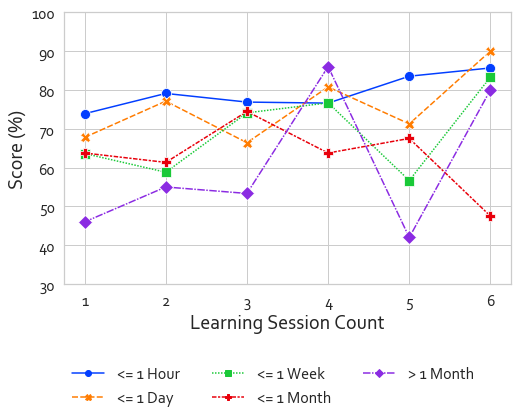

In [12]:
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
    
axs = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
axs = sns.lineplot(x="Iteration",
                  y="Score",
                  ci=None,
                  hue="Gap",
                  palette=sns.color_palette("bright", 5),
                  style="Gap",
                  markers=True,
                  markersize=10,
                  data=table_forgetting_curves)

axs.set_xlabel('Learning Session Count',fontsize=20)
axs.set_ylabel('Score (%)',fontsize=20)
axs.set_xticks(np.arange(1, 7, step=1))
axs.set_yticks(np.arange(30, 105, step=10))
handles, labels = axs.get_legend_handles_labels()
plt.legend(handles=handles[1:], labels=labels[1:],fontsize=16,ncol=3, bbox_to_anchor=(.95, -0.25))
for lh in axs.legend_.legendHandles: 
    lh._sizes = [100]
plt.show()

## Missing data dropped users (based on sequence length)

In [13]:
count_attempts = (life_play_data.groupby('User').Question.count()).to_frame()
count_attempts.reset_index(inplace=True)
count_attempts

for i in range(3,11,1):
    print("Missing less than {}: N={},({:.2%})".format(
            i,
            count_attempts.User[count_attempts.Question < i].nunique(),
            count_attempts.User[count_attempts.Question < i].nunique()/count_attempts.User.nunique()
    ))    

Missing less than 3: N=43,(7.52%)
Missing less than 4: N=64,(11.19%)
Missing less than 5: N=82,(14.34%)
Missing less than 6: N=90,(15.73%)
Missing less than 7: N=98,(17.13%)
Missing less than 8: N=105,(18.36%)
Missing less than 9: N=110,(19.23%)
Missing less than 10: N=115,(20.10%)


In [14]:
##New code
dataset = life_play_data.copy()
dataset.drop(['Session'],axis=1,inplace=True)

#Rearrange columns, make sure Correct is at the end
dataset = dataset[['User','Question','Feedback','Time','Gap','Opportunity','Score','Gap_Log','Correct']]
dataset.Gap = pd.Categorical(dataset.Gap.tolist(),categories=['None', 
                                                                  '<= 1 Hour', 
                                                                  '<= 1 Day', 
                                                                  '<= 1 Week', 
                                                                  '<= 1 Month', 
                                                                  '> 1 Month'])
dataset.Gap = dataset.Gap.cat.codes
dataset.loc[dataset.Time > 29, ['Time']] = 30 #Make all time slots longer than 87 seconds, 90 seconds
dataset.loc[dataset.Opportunity > 19, ['Opportunity']] = 20 #Make all opportunities greater than 19, 20
dataset.tail()

,User,Question,Feedback,Time,Gap,Opportunity,Score,Gap_Log,Correct
18735,549,9,0,4,0,2,2,-4.60517,0
18736,549,10,1,9,0,1,2,-4.60517,0
18737,549,10,0,4,0,2,2,-4.60517,0
18738,549,12,1,20,0,1,2,-4.60517,0
18739,549,12,0,14,0,2,2,-4.60517,0


In [15]:
dataset_autoencode = dataset.copy()# Create a dataset copy to be used for OneHotEncoding
dataset_autoencode.Question = pd.Categorical(dataset_autoencode.Question)
dataset_autoencode.Feedback = pd.Categorical(dataset_autoencode.Feedback)
dataset_autoencode.Time = pd.Categorical(dataset_autoencode.Time)
dataset_autoencode.Gap = pd.Categorical(dataset_autoencode.Gap)
dataset_autoencode.Opportunity = pd.Categorical(dataset_autoencode.Opportunity)
question_dummies = pd.get_dummies(dataset_autoencode.Question, prefix = 'KC')
feedback_dummies = pd.get_dummies(dataset_autoencode.Feedback, prefix = 'Feedback')
time_dummies = pd.get_dummies(dataset_autoencode.Time, prefix = 'Time')
gap_dummies = pd.get_dummies(dataset_autoencode.Gap, prefix = 'Gap')
opportunity_dummies = pd.get_dummies(dataset_autoencode.Opportunity, prefix = 'Opportunity')


dataset_autoencode_onehot = pd.concat([dataset_autoencode, 
               question_dummies,
               feedback_dummies,
               time_dummies,
               gap_dummies,
               opportunity_dummies], axis=1)

#LAK dataset needs this
dataset_autoencode_onehot.drop(['Question','Feedback','Time','Gap','Opportunity'],axis=1,inplace=True)
column_names = dataset_autoencode_onehot.columns.tolist()
column_names.remove('Correct')
column_names.remove('Score')
column_names.remove('Gap_Log')
column_names.append('Gap_Log')
column_names.append('Score')
column_names.append('Correct')
dataset_autoencode_onehot = dataset_autoencode_onehot[column_names]
dataset_autoencode_onehot.Score = dataset_autoencode_onehot.Score * 10
dataset_autoencode_onehot.tail()

,User,KC_1,KC_2,KC_3,KC_4,KC_5,KC_7,KC_9,KC_10,KC_12,...,Opportunity_14,Opportunity_15,Opportunity_16,Opportunity_17,Opportunity_18,Opportunity_19,Opportunity_20,Gap_Log,Score,Correct
18735,549,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,-4.60517,20,0
18736,549,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,-4.60517,20,0
18737,549,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,-4.60517,20,0
18738,549,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,-4.60517,20,0
18739,549,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,-4.60517,20,0


In [16]:
def temporalize(features, labels, lookback): #Converts dataset to timeseries form, with sliding window of varying sizes
    X = []
    y_series = []
    y_single = []
    sets = len(features)-lookback + 1
    for i in range(sets):
        t = []
        l = []
        for j in range(0,lookback):
            # Gather past records upto the lookback period
            t.append(features[[(i+j)], :])            
            l.append(labels[[(i+j)]])
        X.append(t)
        y_single.append(labels[(i+lookback)-1])
        y_series.append(l)
    return X, y_series, y_single

def get_split_dataset(datasets,lookback,keepUserId):
    
    global n_features  
    if keepUserId:
        features = datasets.loc[:, ~(datasets.columns.isin(['Correct']))].values
    else:
        features = datasets.loc[:, ~(datasets.columns.isin(['User','Correct']))].values
        
    labels = datasets.Correct.values    

    X, y_series, y_single = temporalize(features,labels,lookback)

    X = np.array(X)
    if keepUserId:
        X = X.reshape(X.shape[0],lookback,n_features-1) #Just omit the Correct column
    else:
        X = X.reshape(X.shape[0],lookback,n_features-2) #Just omit the Correct & User column
    y_series = np.array(y_series).reshape(np.array(y_series).shape[0],lookback,1)
    y_single = np.array(y_single).reshape(np.array(y_single).shape[0],1)

    return X, y_series, y_single

In [17]:
def get_datasets(dataset,
                 lookback,
                 single_label=False,
                 train_ratio = 0.8,
                 weighted=False,
                 learnerAgnostic=True,
                 keepUserId=False,
                 useSRLusersAsTest=False):
    
    global users_with_demo
    
    if useSRLusersAsTest: #Use dataset with known extra demographic details as the test dataset(~23% of the full dataset)
        
        dataset_test = dataset[dataset.User.isin(users_with_demo)]
        dataset_train = dataset[~dataset.User.isin(users_with_demo)]
        
        learners_data_test = dataset_test.groupby(['User']).apply(get_split_dataset,lookback,keepUserId)
        learners_data_train = dataset_train.groupby(['User']).apply(get_split_dataset,lookback,keepUserId)
        
        X_test, y_test_series,y_test_last = zip(*learners_data_test)
        X_train, y_train_series,y_train_last = zip(*learners_data_train)
        
        X_test = [item for item in X_test if item.shape[0] > 0]
        y_test_series = [item for item in y_test_series if item.shape[0] > 0]
        y_test_last = [item for item in y_test_last if item.shape[0] > 0]
        
        X_train = [item for item in X_train if item.shape[0] > 0]
        y_train_series = [item for item in y_train_series if item.shape[0] > 0]
        y_train_last = [item for item in y_train_last if item.shape[0] > 0]
        
        X_test = np.vstack(X_test)
        y_test_series = np.vstack(y_test_series)
        y_test_last = np.vstack(y_test_last)
        
        X_train = np.vstack(X_train)
        y_train_series = np.vstack(y_train_series)
        y_train_last = np.vstack(y_train_last)
        
        return X_train, X_test, y_train_series, y_test_series   
        
    else:
        learners_data = dataset.groupby(['User']).apply(get_split_dataset,lookback,keepUserId)
    
        #Randomise learners to either test or train
        summary_stats = pd.DataFrame()
        for idx,items in learners_data.iteritems():
            this_stat = pd.DataFrame({
                'Learner':idx,
                'seq_len':items[0].shape[0]
            },index=[idx])
            summary_stats = pd.concat([summary_stats,this_stat])
        summary_stats = summary_stats[summary_stats.seq_len >0]
        summary_stats['Learner']= range(0,summary_stats.shape[0])
        summary_stats['weight'] = summary_stats.seq_len / summary_stats.seq_len.sum()

        np.random.seed(1)

        if weighted:
            train_val_users = np.random.choice(summary_stats.Learner,
                                               size=int(summary_stats.shape[0]*train_ratio), #default 80% of users to train
                                               p=summary_stats.weight, #Weight by number of sequences per user
                                               replace=False)
            test_users = list(set(summary_stats.Learner.tolist()).difference(set(train_val_users.tolist())))
        else:
            train_val_users = np.random.choice(summary_stats.Learner,
                                               size=int(summary_stats.shape[0]*train_ratio), #default 80% of users to train
                                               replace=False)
            test_users = list(set(summary_stats.Learner.tolist()).difference(set(train_val_users.tolist())))



        features, labels, last_label = zip(*learners_data)

        features_remain = [item for item in features if item.shape[0] > 0]
        labels_remain = [item for item in labels if item.shape[0] > 0]
        last_label_remain = [item for item in last_label if item.shape[0] > 0]

        #Split the data for model training
        if learnerAgnostic:
            X = np.vstack(features_remain)
            y = np.vstack(labels_remain)
            y_single = np.vstack(last_label_remain)

            if single_label:
                X_train_val,X_test,y_train_val,y_test = train_test_split(X, y_single,test_size=(1.0-train_ratio),
                                                                         shuffle=True,random_state=1)
            else:
                X_train_val,X_test,y_train_val,y_test = train_test_split(X, y,test_size=(1.0-train_ratio),
                                                                         shuffle=True,random_state=1)

            return X_train_val, X_test, y_train_val, y_test

        else:            
            X_train_val = list(itemgetter(*train_val_users)(features_remain))
            X_train_val = np.vstack(X_train_val)

            X_test = list(itemgetter(*test_users)(features_remain))
            X_test = np.vstack(X_test)

            if single_label:
                y_train_val = list(itemgetter(*train_val_users)(last_label_remain))
                y_train_val = np.vstack(y_train_val)
                y_test = list(itemgetter(*test_users)(last_label_remain))
                y_test = np.vstack(y_test)
            else:
                y_train_val = list(itemgetter(*train_val_users)(labels_remain))
                y_train_val = np.vstack(y_train_val)
                y_test = list(itemgetter(*test_users)(labels_remain))
                y_test = np.vstack(y_test) 

            return X_train_val, X_test, y_train_val, y_test    

In [18]:
class PrintDot(Callback): #Keep track of progress
    def on_epoch_end(self, epoch, logs):
        if epoch % 500 == 0: print('')
        if epoch % 30 == 0: print('.', end='')        
        
es = EarlyStopping(monitor='val_loss',patience=4)  #Avoid overfitting      
cp = ModelCheckpoint(filepath="dkt_LIFE_AE.h5", #Save best performing model
                     monitor='val_loss',
                     save_best_only=True,
                     verbose=0,mode='max')

In [19]:
def get_dkt_model(feature_size,n_out,y_out):
    # define encoder
    visible = Input(shape=(n_out,feature_size),name='input_layer')
              
    deep_layer= LSTM(32,
                   activation='relu',                   
                   return_sequences=True,
                   kernel_regularizer=l2(10e-4),
                   recurrent_regularizer=l2(10e-4),                   
                   dropout=0.2,
                   recurrent_dropout=0.2,
                   name='in_layer_one')(visible)
    
    encoder = LSTM(16,                      #Compression rate = 16/n_features
                   activation='relu',                   
                   name='encoder_layer')(deep_layer)   
    
    #define reconstruct decoder
    reconstruct_decoder = RepeatVector(n_out,name='reco_repeat')(encoder)    
    reconstruct_decoder = LSTM(32, 
                               activation='relu', 
                               return_sequences=True,
                               name='out_layer_one')(reconstruct_decoder)    
    reconstruct_decoder = TimeDistributed(Dense(X_train_val.shape[2],activation='sigmoid',name='sig_reco')
                                          ,name='reco_td')(reconstruct_decoder)
    
    #define predict decoder
    predict_decoder = RepeatVector(n_out,name='pred_repeat')(encoder)  
    predict_decoder = LSTM(1,                           
                           activation='relu',
                           kernel_regularizer=l2(10e-4),
                           recurrent_regularizer=l2(10e-4),
                           dropout=0.5,                       
                           recurrent_dropout=0.5,                          
                           return_sequences=False,
                           name='strip_lagsteps')(predict_decoder)   
    predict_decoder = Dense(y_out,activation='sigmoid',name='pred_td')(predict_decoder)
    
    
    # tie it together
    model = Model(inputs=visible, outputs=[reconstruct_decoder,predict_decoder],name='Composite_AutoEncoder')
    adam = tf.keras.optimizers.Adam(lr=0.001)
    model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['accuracy'])
    
    return model

## OneHot AE Model (Many-to-One LSTM)

In [20]:
try:
    summary_stats = pd.read_csv(MODEL_ROOT_DOC+'cvmodel_perf_onehot_mto.csv')
    start_lookback = summary_stats.Lookback.max()
    fold = summary_stats.Fold.iloc[-1]
    if fold == 10:
        fold = 1
        start_lookback+=1
    else:
        fold +=1
except FileNotFoundError:
    summary_stats = pd.DataFrame() #Keeps track of model performance over the different sequence lengths
    start_lookback = 3
    fold = 1

In [21]:
#Ensure reproducability
random.seed(1) 
tf.random.set_seed(1)

for lookback in range(start_lookback,11,1):
    
    tf.random.set_seed(1)
    n_features = dataset_autoencode_onehot.shape[1] #-1, used in get_split_dataset function
    
    X_train_val, X_test, y_train_val, y_test = get_datasets(dataset_autoencode_onehot, 
                                                            lookback, #timesteps
                                                            single_label=False, #Outcome at last step only?
                                                            learnerAgnostic=False, #Mix sequences from learners in train&test
                                                            train_ratio=0.7,
                                                            weighted=False, #Weight ratio by individual learner data
                                                            keepUserId=True, #If you want to keep track of user features
                                                            useSRLusersAsTest=False)
    
    n_in = lookback
    n_out = lookback -1
    X_train_val = X_train_val[:,:-1,1:-2]
    X_test = X_test[:,:-1,1:-2] 
    
    y_train_seq = (y_train_val[:,-1:,:]).reshape(-1,1)# Predict the outcome of the last step
    y_test_seq = (y_test[:,-1:,:]).reshape(-1,1)# Predict the outcome of the last step
    
    
    
    
    print()
    print("Lookback: "+str(lookback))
    
    
    n_split=10 #n-fold cross-validation
    skip = 1
    
    #  Apply 10-fold cross-validation
    for train_index,val_index in KFold(n_split,random_state=1).split(X_train_val):
        
        x_train,x_val=X_train_val[train_index],X_train_val[val_index]
        y_train,y_val=y_train_seq[train_index],y_train_seq[val_index]
        
        if(skip >= fold):     
            
            model = get_dkt_model(x_train.shape[2],n_out,y_train.shape[1])

            history = model.fit(x_train,[x_train,y_train], 
                      validation_data=(x_val,[x_val,y_val]),
                      epochs=1000,
                      callbacks=[es,cp,PrintDot()],
                      batch_size=64,
                      shuffle=True,
                      verbose=0)


            hat_values_test = model.predict(tf.convert_to_tensor(X_test,dtype=tf.float32), verbose=0)
            Xhat = hat_values_test[0]
            yhat = hat_values_test[1]

            actual = y_test_seq.ravel()
            pred = yhat.ravel()
            
            #Model metrics
            fpr_embed, tpr_embed, thresholds_embed = roc_curve(actual, pred)
            precision, recall, thresholds = precision_recall_curve(actual, pred)

            auc_embed = auc(fpr_embed, tpr_embed)

            bin_pred = [1 if p > 0.5 else 0 for p in pred]

            accuracy_embed = accuracy_score(actual, bin_pred) #Accuracy score
            precision_embed = precision_score(actual, bin_pred, average='weighted') #Precision score
            recall_embed = recall_score(actual, bin_pred, average='weighted') #Recall score
            f1_embed = f1_score(actual, bin_pred, average='weighted') #Recall score

            y_label = K.constant(actual)
            y_pred = K.constant(pred)
            g = K.binary_crossentropy(target=y_label, output=y_pred)  # tensor
            log_loss = np.sum(K.eval(g))


            this_stat = pd.DataFrame({
                'Lookback':lookback,
                'Fold':fold,
                'AUC':auc_embed,
                'AUC_PR':auc(recall,precision),
                'Log_Loss':np.sum(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_label,
                                                                                        logits=y_pred))),
                'Brier_Score':brier_score_loss(actual,pred),
                'Accuracy':accuracy_embed,
                'Precision':precision_embed,
                'Recall':recall_embed,
                'F1':f1_embed
            },index=[lookback])     

            summary_stats = pd.concat([summary_stats,this_stat])
            summary_stats.to_csv(MODEL_ROOT_DOC+'cvmodel_perf_onehot_mto.csv',index=False)

            del model
            del history
            model = None
            history = None 
            gc.collect()
            
            fold +=1
            if fold == 11:
                fold = 1
        skip+=1   

## OneHot AE Model (Many-to-Many LSTM)

In [22]:
try:
    summary_stats_series = pd.read_csv(MODEL_ROOT_DOC+'cvmodel_perf_onehot_mtm.csv')
    start_lookback = summary_stats_series.Lookback.max()
    fold = summary_stats_series.Fold.iloc[-1]
    if fold == 10:
        fold = 1
        start_lookback+=1
    else:
        fold +=1
except FileNotFoundError:
    summary_stats_series = pd.DataFrame() #Keeps track of model performance over the different sequence lengths
    start_lookback = 3
    fold = 1

In [23]:
#Ensure reproducability
random.seed(1) 
tf.random.set_seed(1)

for lookback in range(start_lookback,11,1):
    
    tf.random.set_seed(1)

    n_features = dataset_autoencode_onehot.shape[1] #-1, used in get_split_dataset function
    
    X_train_val, X_test, y_train_val, y_test = get_datasets(dataset_autoencode_onehot, 
                                                            lookback, #timesteps
                                                            single_label=False, #Outcome at last step only?
                                                            learnerAgnostic=False, #Mix sequences from learners in train&test
                                                            train_ratio=0.7,
                                                            weighted=False, #Weight ratio by individual learner data
                                                            keepUserId=True, #If you want to keep track of user features
                                                            useSRLusersAsTest=False)
    
    n_in = lookback
    n_out = lookback -1
    
    X_train_val = X_train_val[:,:-1,1:-2]
    X_test = X_test[:,:-1,1:-2] 
    
    y_train_seq = y_train_val[:,1:,:]# Predict the outcome of each next step
    y_test_seq = y_test[:,1:,:]# Predict the outcome of each next step
    
    print()
    print("Lookback: "+str(lookback))
    
    
    n_split=10 #n-fold cross-validation
    skip = 1
    
    #Apply cross-validation    
    for train_index,val_index in KFold(n_split,random_state=1).split(X_train_val):
        
        if(skip >= fold):                 
            
            x_train,x_val=X_train_val[train_index],X_train_val[val_index]
            y_train,y_val=y_train_seq[train_index],y_train_seq[val_index]

            model = get_dkt_model(X_train_val.shape[2],n_out,y_train_seq.shape[1])

            history = model.fit(x_train,[x_train,y_train], 
                      validation_data=(x_val,[x_val,y_val]),
                      epochs=1000,
                      #validation_split = 0.5, 
                      callbacks=[es,cp,PrintDot()],
                      batch_size=32,
                      shuffle=True,
                      verbose=0)


            hat_values_test = model.predict(tf.convert_to_tensor(X_test,dtype=tf.float32), verbose=0)
            Xhat = hat_values_test[0]
            yhat = hat_values_test[1]

            actual = y_test_seq[:,-1:,:].ravel()
            pred = yhat[:,-1:].ravel()

            #Model metrics
            fpr_embed, tpr_embed, thresholds_embed = roc_curve(actual, pred)
            precision, recall, thresholds = precision_recall_curve(actual, pred)

            auc_embed = auc(fpr_embed, tpr_embed)

            bin_pred = [1 if p > 0.5 else 0 for p in pred]

            accuracy_embed = accuracy_score(actual, bin_pred) #Accuracy score
            precision_embed = precision_score(actual, bin_pred, average='weighted') #Precision score
            recall_embed = recall_score(actual, bin_pred, average='weighted') #Recall score
            f1_embed = f1_score(actual, bin_pred, average='weighted') #Recall score

            y_label = K.constant(actual)
            y_pred = K.constant(pred)
            g = K.binary_crossentropy(target=y_label, output=y_pred)  # tensor
            log_loss = np.sum(K.eval(g))


            this_stat = pd.DataFrame({
                'Lookback':lookback,
                'Fold':fold,
                'AUC':auc_embed,
                'AUC_PR':auc(recall,precision),
                'Log_Loss':np.sum(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_label,
                                                                                        logits=y_pred))),
                'Brier_Score':brier_score_loss(actual,pred),
                'Accuracy':accuracy_embed,
                'Precision':precision_embed,
                'Recall':recall_embed,
                'F1':f1_embed
            },index=[lookback])     

            summary_stats_series = pd.concat([summary_stats_series,this_stat]) 

            summary_stats_series.to_csv(MODEL_ROOT_DOC+'cvmodel_perf_onehot_mtm.csv',index=False)


            del model
            del history
            model = None
            history = None 
            gc.collect()
            
            fold +=1
            if fold == 11:
                fold = 1
        skip+=1               
    

In [24]:
try:
    summary_stats    
except NameError:
    summary_stats = pd.read_csv(MODEL_ROOT_DOC+'cvmodel_perf_onehot_mto.csv')
    
try:
    summary_stats_series
except NameError:
    summary_stats_series = pd.read_csv(MODEL_ROOT_DOC+'cvmodel_perf_onehot_mtm.csv')

    
summary_stats['Type']= 'Last Step'
summary_stats_series['Type']='Series'

cv_model_performance = pd.concat([summary_stats,summary_stats_series],axis=0)

cv_perf = cv_model_performance.groupby(['Lookback','Type']).agg(
    cv_AUC = pd.NamedAgg(column='AUC',aggfunc=np.mean),
    cv_Brier = pd.NamedAgg(column='Brier_Score',aggfunc=np.mean),
    cv_F1 = pd.NamedAgg(column='F1',aggfunc=np.mean),
    cv_Accuracy = pd.NamedAgg(column='Accuracy',aggfunc=np.mean),
    cv_LogLoss = pd.NamedAgg(column='Log_Loss',aggfunc=np.mean)
)
cv_perf.reset_index(inplace=True)
cv_perf.rename(columns={'cv_AUC':'AUC','cv_Brier':'Brier','cv_F1':'F1',
                        'cv_Accuracy':'Accuracy','cv_LogLoss':'LogLoss'},inplace=True)
cv_perf = cv_perf[cv_perf.Lookback < 11]
cv_perf.head()

,Lookback,Type,AUC,Brier,F1,Accuracy,LogLoss
0,3,Last Step,0.917045,0.107936,0.848860,0.848126,3233.797081
1,3,Series,0.869500,0.135694,0.813461,0.814760,3377.230560
2,4,Last Step,0.919078,0.109075,0.840647,0.840104,3393.373706
3,4,Series,0.857638,0.151089,0.791154,0.794746,3581.432813
4,5,Last Step,0.914882,0.112363,0.837239,0.837213,3353.321606


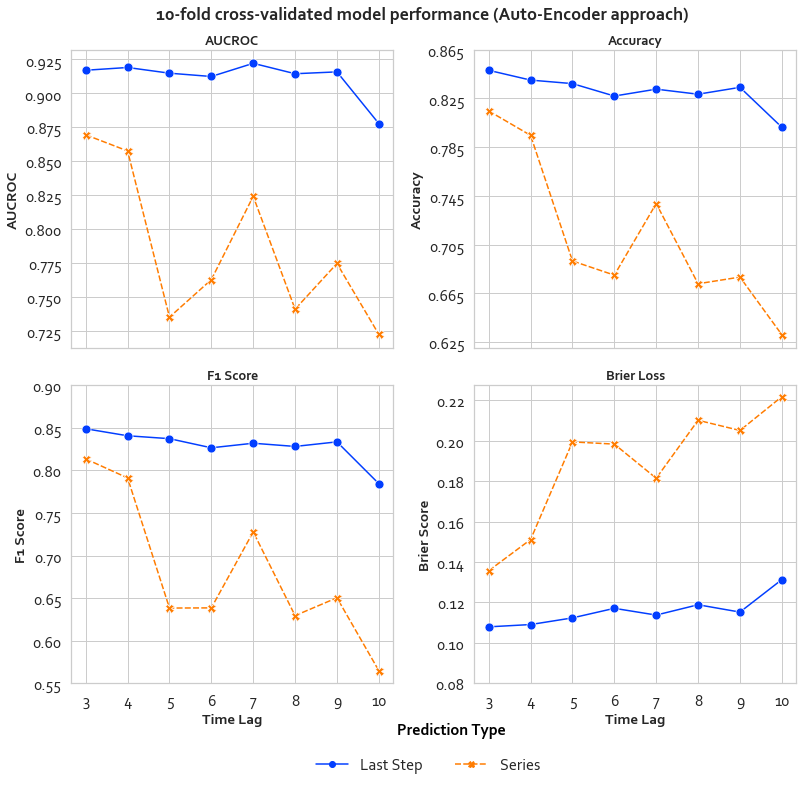

In [25]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(13,11))

filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
dash_styles = ["",
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2)]

g = sns.lineplot(x="Lookback",y="AUC",hue="Type",
                 palette=sns.color_palette("bright", 2),
                 style="Type",
                 dashes=dash_styles,
                 markers=True,
                 data=cv_perf,
                 ax=axs[0,0],legend="full",markersize=9,linewidth=1.5)
g.legend_.remove()
g.set(xticklabels=[])
axs[0,0].set_xlabel('')
axs[0,0].set_xticks(np.arange(3, 11, step=1))
axs[0,0].set_title("AUCROC",weight='bold').set_fontsize('14')
axs[0,0].set_ylabel('AUCROC',fontsize=15,weight='bold')

h = sns.lineplot(x="Lookback",y="Accuracy",hue="Type",
                 palette=sns.color_palette("bright", 2),
                 style="Type",
                 dashes=dash_styles,
                 markers=True,
                 data=cv_perf,
                 ax=axs[0,1],legend="full",markersize=9,linewidth=1.5)
h.legend_.remove()
h.set(xticklabels=[])
axs[0,1].set_xlabel('')
axs[0,1].set_xticks(np.arange(3, 11, step=1))
axs[0,1].set_yticks(np.arange(.625, .877, step=.04))
axs[0,1].set_title("Accuracy",weight='bold').set_fontsize('14')
axs[0,1].set_ylabel('Accuracy',fontsize=15,weight='bold')

i = sns.lineplot(x="Lookback",y="F1",hue="Type",
                 palette=sns.color_palette("bright", 2),
                 style="Type",
                 dashes=dash_styles,
                 markers=True,
                 data=cv_perf,
                 ax=axs[1,0],legend="full",markersize=9,linewidth=1.5)
i.legend_.remove()
axs[1,0].set_title("F1 Score",weight='bold').set_fontsize('14')
axs[1,0].set_xticks(np.arange(3, 11, step=1))
axs[1,0].set_yticks(np.arange(.55, .91, step=.05))
axs[1,0].set_xlabel('Time Lag',fontsize=15,weight='bold')
axs[1,0].set_ylabel('F1 Score',fontsize=15,weight='bold')

j = sns.lineplot(x="Lookback",y="Brier",hue="Type",
                 palette=sns.color_palette("bright", 2),
                 style="Type",
                 dashes=dash_styles,
                 markers=True,
                 data=cv_perf,
                 ax=axs[1,1],legend="full",markersize=9,linewidth=1.5)
j.legend_.remove()
axs[1,1].set_title("Brier Loss",weight='bold').set_fontsize('14')
axs[1,1].set_xticks(np.arange(3, 11, step=1))
axs[1,1].set_yticks(np.arange(.08, .23, step=.02))
axs[1,1].set_xlabel('Time Lag',fontsize=15,weight='bold')
axs[1,1].set_ylabel('Brier Score',fontsize=15,weight='bold')

fig.subplots_adjust(hspace = .125,top=0.925, wspace=.25)

handles, labels = axs[1,1].get_legend_handles_labels()
plt.legend(handles=handles[1:], labels=labels[1:],fontsize=16,ncol=2, bbox_to_anchor=(0.25, -0.2))
plt.text(0.8, .055, "Prediction Type", horizontalalignment='left', fontsize=16, color='black', weight='semibold')
fig.suptitle("10-fold cross-validated model performance (Auto-Encoder approach)",fontsize=18,weight='bold')
plt.show()




# Embedding layers for explanatory variables

An embedding layer maps each element in a set of discrete things (like words, users, or movies) to a dense vector of real numbers (its embedding).

Aside: A key implementation detail is that embedding layers take as input the index of the entity being embedded (i.e. we can give it our User IDs as input). You can think of it as a sort of 'lookup table'. This is much more efficient than taking a one-hot vector and doing a huge matrix multiplication!

Where do these come from? We initialize an embedding for each user and question using random noise, then we train them as part of the process of training the overall learning-prediction model.

What do they mean? An object's embedding, if it's any good, should capture some useful latent properties of that object. But the key word here is _*latent*_ AKA hidden. It's up to the model to discover whatever properties of the entities are useful for the prediction task, and encode them in the embedding space. Sound mysterious? In later analysis, I'll show some techniques for interpreting learned embeddings, such as visualizing them with the t-SNE algorithm.

In [26]:
users_max = (dataset.User.max()+1)
quiz_max = (dataset.Question.max()+1)
opportunity_max = (dataset.Opportunity.max()+1)
time_max = (dataset.Time.max()+1)
feedback_max = (dataset.Feedback.max()+1)
space_max = (dataset.Gap.max()+1)

In [27]:
def get_dkt_model(last_x,series=False):
       
    # Each instance will consist of two inputs: a single user id, and a single question id
    user_id_input = Input(shape=(last_x,), name='user_id')
    quiz_id_input = Input(shape=(last_x,), name='quiz_id')
    feedback_id_input = Input(shape=(last_x,), name='feedback_id')
    time_id_input = Input(shape=(last_x,), name='time_id')
    space_id_input = Input(shape=(last_x,), name='space_id')
    opp_id_input = Input(shape=(last_x,), name='opp_id')

    user_embedded = Embedding(users_max,8,input_length=last_x, name='user_embedding')(user_id_input)
    quiz_embedded = Embedding(quiz_max, 8,input_length=last_x, name='quiz_embedding')(quiz_id_input)
    feedback_embedded = Embedding(feedback_max, 8,input_length=last_x, name='feedback_embedding')(feedback_id_input)
    time_embedded = Embedding(time_max, 8,input_length=last_x, name='time_embedding')(time_id_input)
    space_embedded = Embedding(space_max, 8,input_length=last_x, name='space_embedding')(space_id_input)
    opp_embedded = Embedding(opportunity_max, 8,input_length=last_x, name='opp_embedding')(opp_id_input)

    concatenated=Concatenate(name='concat_embeddings')([user_embedded,
                                                quiz_embedded,
                                                feedback_embedded,
                                                time_embedded,
                                                space_embedded,
                                                opp_embedded])
    out = LSTM(32,
               activation='relu',
               kernel_regularizer=l2(10e-4),
               recurrent_regularizer=l2(10e-4), 
               return_sequences=series,
               dropout=0.5,
               recurrent_dropout=0.5,
               name='lstm_layer_outer')(concatenated)
    out = Dense(1, activation='sigmoid',name='prediction_layer')(out)   


    model = Model(
        inputs = [user_id_input,quiz_id_input,feedback_id_input,time_id_input,space_id_input,opp_id_input],
        outputs = out,
    ) 

    adam = tf.keras.optimizers.Adam(lr=0.0005)
    model.compile(loss='binary_crossentropy', optimizer = adam, metrics=['accuracy'])
    
    return model

In [40]:
try:
    summary_stats = pd.read_csv(MODEL_ROOT_DOC+'cvmodel_perf_embed_mto.csv')
    start_lookback = summary_stats.Lookback.max()
    fold = summary_stats.Fold.iloc[-1]
    if fold == 10:
        fold = 1
        start_lookback+=3
    else:
        fold +=1
except FileNotFoundError:
    summary_stats = pd.DataFrame() #Keeps track of model performance over the different sequence lengths
    start_lookback = 3
    fold = 1

## Embedding Model (Many-to-One LSTM)

In [41]:
#Ensure reproducability
random.seed(1) 
tf.random.set_seed(1)

for lookback in range(start_lookback,31,3):
    
    tf.random.set_seed(1)

    n_features = dataset.shape[1] #-1, used in get_split_dataset function
    
    X_train_val, X_test, y_train_val, y_test = get_datasets(dataset, 
                                                            lookback, #timesteps
                                                            single_label=False, #Outcome at last step only?
                                                            learnerAgnostic=False, #Mix sequences from learners in train&test
                                                            train_ratio=0.7,
                                                            weighted=False, #Weight ratio by individual learner data
                                                            keepUserId=True, #If you want to keep track of user features
                                                            useSRLusersAsTest=True)
    
    last_x = int(lookback - 1)
    X_train_val = X_train_val[:,:-1,:]
    X_test = X_test[:,:-1,:]
    
    y_train_seq = (y_train_val[:,-1:,:]).reshape(y_train_val.shape[0],1) #Only predict the last step from this sequence
    y_test = (y_test[:,-1:,:]).reshape(y_test.shape[0],1) #Only predict the last step from this sequence
    
    print()
    print("Lookback: "+str(lookback))
    
    user_test = [item[:,0] for item in X_test]
    quiz_test = [item[:,1] for item in X_test]
    feedback_test = [item[:,2] for item in X_test]
    time_test = [item[:,3] for item in X_test]
    space_test = [item[:,4] for item in X_test]
    opp_test = [item[:,5] for item in X_test]
    
    embeddings_test = [user_test,quiz_test,feedback_test,time_test,space_test,opp_test]
    
    n_split=10 #n-fold cross-validation
    skip = 1
    
    #Apply cross-validation    
    for train_index,val_index in KFold(n_split,random_state=1).split(X_train_val):
        
        if(skip >= fold):                 
            
            x_train,x_val=X_train_val[train_index],X_train_val[val_index]
            y_train,y_val=y_train_seq[train_index],y_train_seq[val_index]
            
            user_train = [item[:,0] for item in x_train]
            quiz_train = [item[:,1] for item in x_train]
            feedback_train = [item[:,2] for item in x_train]
            time_train = [item[:,3] for item in x_train]
            space_train = [item[:,4] for item in x_train]
            opp_train = [item[:,5] for item in x_train]
            
            user_val = [item[:,0] for item in x_val]
            quiz_val = [item[:,1] for item in x_val]
            feedback_val = [item[:,2] for item in x_val]
            time_val = [item[:,3] for item in x_val]
            space_val = [item[:,4] for item in x_val]
            opp_val = [item[:,5] for item in x_val]

            embeddings_train = [user_train,quiz_train,feedback_train,time_train,space_train,opp_train]
            embeddings_val = [user_val,quiz_val,feedback_val,time_val,space_val,opp_val]
            

            model = get_dkt_model(last_x,series=False)
            
            history = model.fit(
                  embeddings_train,y_train,
                  validation_data=(embeddings_val,y_val),
                  epochs=1000, 
                  batch_size=256,
                  shuffle=True,
                  verbose=0,
                  callbacks=[es,cp])

            y_pred = model.predict(embeddings_test,batch_size=y_test.shape[0])
            
            actual = y_test.ravel()
            pred = y_pred.ravel()

            fpr_embed, tpr_embed, thresholds_embed = roc_curve(actual, pred)
            auc_embed = auc(fpr_embed, tpr_embed)

            bin_pred = [1 if p > 0.5 else 0 for p in pred]

            accuracy_embed = accuracy_score(actual, bin_pred) #Accuracy score
            precision_embed = precision_score(actual, bin_pred, average='weighted') #Precision score
            recall_embed = recall_score(actual, bin_pred, average='weighted') #Recall score
            f1_embed = f1_score(actual, bin_pred, average='weighted') #Recall score

            this_stat = pd.DataFrame({
                'Lookback':lookback,
                'Fold':fold,
                'AUC':auc_embed,
                'Accuracy':accuracy_embed,
                'Precision':precision_embed,
                'Recall':recall_embed,
                'F1':f1_embed,
                'Brier_Score':brier_score_loss(actual,pred)
            },index=[lookback])

            summary_stats = pd.concat([summary_stats,this_stat])
            summary_stats.to_csv(MODEL_ROOT_DOC+'cvmodel_perf_embed_mto.csv',index=False)
            
            
            del model
            del history
            model = None
            history = None 
            gc.collect()
            
            fold +=1
            if fold == 11:
                fold = 1
        skip+=1

## Embedding Model (Many-to-Many LSTM)

In [46]:
try:
    summary_stats_series = pd.read_csv(MODEL_ROOT_DOC+'cvmodel_perf_embed_mtm.csv')
    start_lookback = summary_stats_series.Lookback.max()
    fold = summary_stats_series.Fold.iloc[-1]
    if fold == 10:
        fold = 1
        start_lookback+=3
    else:
        fold +=1
except FileNotFoundError:
    summary_stats_series = pd.DataFrame() #Keeps track of model performance over the different sequence lengths
    start_lookback = 3
    fold = 1

In [47]:
#Ensure reproducability
random.seed(1) 
tf.random.set_seed(1)

for lookback in range(start_lookback,31,3):
    
    tf.random.set_seed(1)
    n_features = dataset.shape[1] #-1, used in get_split_dataset function
    
    X_train_val, X_test, y_train_val, y_test = get_datasets(dataset, 
                                                            lookback, #timesteps
                                                            single_label=False, #Outcome at last step only?
                                                            learnerAgnostic=False, #Mix sequences from learners in train&test
                                                            train_ratio=0.7,
                                                            weighted=False, #Weight ratio by individual learner data
                                                            keepUserId=True, #If you want to keep track of user features
                                                            useSRLusersAsTest=True)
    
    last_x = int(lookback - 1)
    X_train_val = X_train_val[:,:-1,:]
    X_test = X_test[:,:-1,:]
    
    y_train_val = y_train_val[:,1:,:] #Predict outcome of subsequent steps
    y_test = y_test[:,1:,:]#Predict outcome of subsequent steps
    
    user_test = [item[:,0] for item in X_test]
    quiz_test = [item[:,1] for item in X_test]
    feedback_test = [item[:,2] for item in X_test]
    time_test = [item[:,3] for item in X_test]
    space_test = [item[:,4] for item in X_test]
    opp_test = [item[:,5] for item in X_test]
    
    print()
    print("Lookback: "+str(lookback))
    
    embeddings_test = [user_test,quiz_test,feedback_test,time_test,space_test,opp_test]
    
    n_split=10 #n-fold cross-validation
    skip = 1
    
    #Apply cross-validation    
    for train_index,val_index in KFold(n_split,random_state=1).split(X_train_val):
        
        if(skip >= fold):                 
            
            x_train,x_val=X_train_val[train_index],X_train_val[val_index]
            y_train,y_val=y_train_val[train_index],y_train_val[val_index]
            
            user_train = [item[:,0] for item in x_train]
            quiz_train = [item[:,1] for item in x_train]
            feedback_train = [item[:,2] for item in x_train]
            time_train = [item[:,3] for item in x_train]
            space_train = [item[:,4] for item in x_train]
            opp_train = [item[:,5] for item in x_train]
            
            user_val = [item[:,0] for item in x_val]
            quiz_val = [item[:,1] for item in x_val]
            feedback_val = [item[:,2] for item in x_val]
            time_val = [item[:,3] for item in x_val]
            space_val = [item[:,4] for item in x_val]
            opp_val = [item[:,5] for item in x_val]

            embeddings_train = [user_train,quiz_train,feedback_train,time_train,space_train,opp_train]
            embeddings_val = [user_val,quiz_val,feedback_val,time_val,space_val,opp_val]
            
            model = get_dkt_model(last_x,series=True)
            
            history = model.fit(
                  embeddings_train,y_train,
                  validation_data=(embeddings_val,y_val),
                  epochs=1000, 
                  batch_size=256,
                  shuffle=True,
                  verbose=0,
                  callbacks=[es,cp])

            y_pred = model.predict(embeddings_test,batch_size=y_test.shape[0])
            
            actual = y_test[:,-1:,:].ravel() # Get last step only
            pred = y_pred[:,-1:].ravel() # Get last step only
            
            fpr_embed, tpr_embed, thresholds_embed = roc_curve(actual, pred)
            auc_embed = auc(fpr_embed, tpr_embed)

            bin_pred = [1 if p > 0.5 else 0 for p in pred]

            accuracy_embed = accuracy_score(actual, bin_pred) #Accuracy score
            precision_embed = precision_score(actual, bin_pred, average='weighted') #Precision score
            recall_embed = recall_score(actual, bin_pred, average='weighted') #Recall score
            f1_embed = f1_score(actual, bin_pred, average='weighted') #Recall score

            this_stat = pd.DataFrame({
                'Lookback':lookback,
                'Fold':fold,
                'AUC':auc_embed,
                'Accuracy':accuracy_embed,
                'Precision':precision_embed,
                'Recall':recall_embed,
                'F1':f1_embed,
                'Brier_Score':brier_score_loss(actual,pred)
            },index=[lookback])

            summary_stats_series = pd.concat([summary_stats_series,this_stat])
            summary_stats_series.to_csv(MODEL_ROOT_DOC+'cvmodel_perf_embed_mtm.csv',index=False)
            
            
            del model
            del history
            model = None
            history = None 
            gc.collect()
            
            fold +=1
            if fold == 11:
                fold = 1
        skip+=1


Lookback: 3

Lookback: 6

Lookback: 9

Lookback: 12

Lookback: 15

Lookback: 18

Lookback: 21

Lookback: 24

Lookback: 27

Lookback: 30


In [49]:
try:
    summary_stats    
except NameError:
    summary_stats = pd.read_csv(MODEL_ROOT_DOC+'cvmodel_perf_embed_mto.csv')
    
try:
    summary_stats_series
except NameError:
    summary_stats_series = pd.read_csv(MODEL_ROOT_DOC+'cvmodel_perf_embed_mtm.csv')

    
summary_stats['Type']= 'Last Step'
summary_stats_series['Type']='Series'

cv_model_performance = pd.concat([summary_stats,summary_stats_series],axis=0)

model_performance = cv_model_performance.groupby(['Lookback','Type']).agg(
    cv_AUC = pd.NamedAgg(column='AUC',aggfunc=np.mean),
    cv_Brier = pd.NamedAgg(column='Brier_Score',aggfunc=np.mean),
    cv_F1 = pd.NamedAgg(column='F1',aggfunc=np.mean),
    cv_Accuracy = pd.NamedAgg(column='Accuracy',aggfunc=np.mean)
)
model_performance.reset_index(inplace=True)
model_performance.rename(columns={'cv_AUC':'AUC','cv_Brier':'Brier','cv_F1':'F1',
                        'cv_Accuracy':'Accuracy'},inplace=True)
model_performance.head()

,Lookback,Type,AUC,Brier,F1,Accuracy
0,3,Last Step,0.895516,0.122596,0.826722,0.827597
1,3,Series,0.895136,0.121661,0.826820,0.827800
2,6,Last Step,0.896355,0.122709,0.828615,0.830006
3,6,Series,0.903570,0.115963,0.833334,0.835543
4,9,Last Step,0.881217,0.136367,0.814090,0.815373


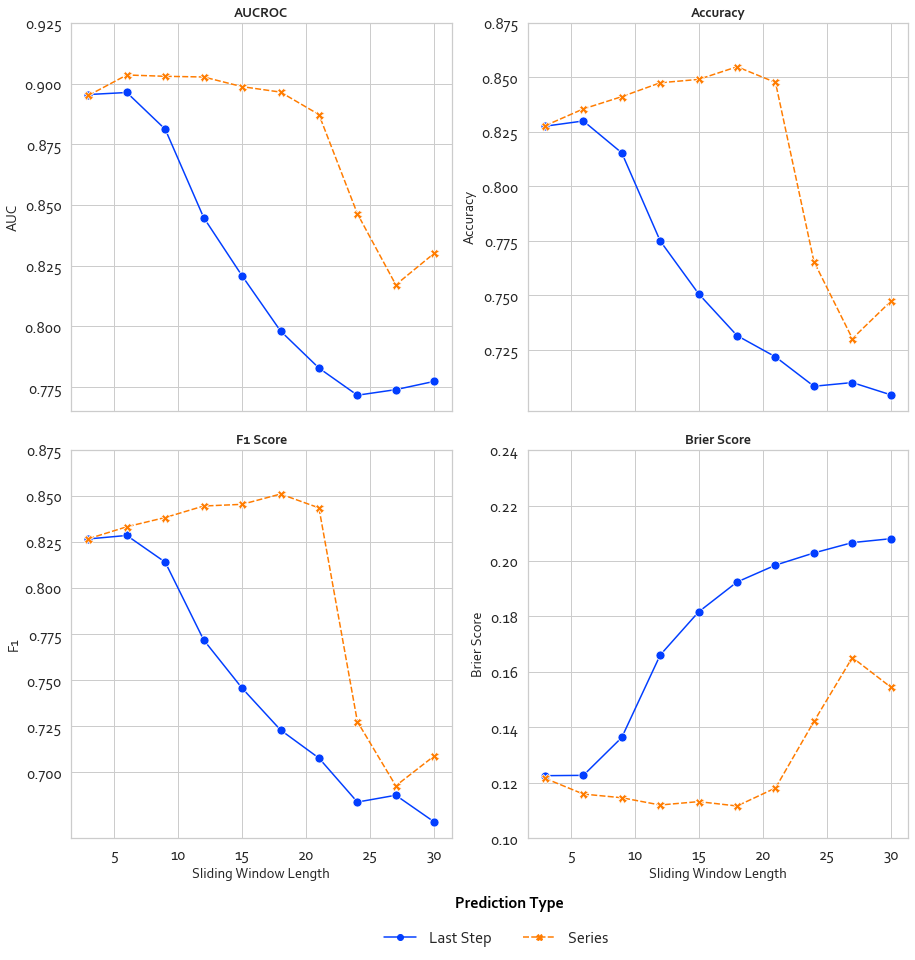

In [51]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(15,15))

filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
dash_styles = ["",
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2)]

g = sns.lineplot(x="Lookback",y="AUC",hue="Type",
                 palette=sns.color_palette("bright", 2),
                 style="Type",
                 dashes=dash_styles,
                 markers=True,
                 data=model_performance,
                 ax=axs[0,0],legend="full",markersize=9,linewidth=1.5)
g.legend_.remove()
g.set(xticklabels=[])
axs[0,0].set_xlabel('')
axs[0,0].set_title("AUCROC",weight='bold').set_fontsize('14')
axs[0,0].set_yticks(np.arange(.775, .925, step=.025))

h = sns.lineplot(x="Lookback",y="Accuracy",hue="Type",
                 palette=sns.color_palette("bright", 2),
                 style="Type",
                 dashes=dash_styles,
                 markers=True,
                 data=model_performance,
                 ax=axs[0,1],legend="full",markersize=9,linewidth=1.5)
h.legend_.remove()
h.set(xticklabels=[])
axs[0,1].set_xlabel('')
axs[0,1].set_title("Accuracy",weight='bold').set_fontsize('14')
axs[0,1].set_yticks(np.arange(.725, .875, step=.025))        

i = sns.lineplot(x="Lookback",y="F1",hue="Type",
                 palette=sns.color_palette("bright", 2),
                 style="Type",
                 dashes=dash_styles,
                 markers=True,
                 data=model_performance,
                 ax=axs[1,0],legend="full",markersize=9,linewidth=1.5)
i.legend_.remove()
axs[1,0].set_xlabel('Sliding Window Length')
axs[1,0].set_title("F1 Score",weight='bold').set_fontsize('14')
axs[1,0].set_yticks(np.arange(.7, .875, step=.025))

j = sns.lineplot(x="Lookback",y="Brier",hue="Type",
                 palette=sns.color_palette("bright", 2),
                 style="Type",
                 dashes=dash_styles,
                 markers=True,
                 data=model_performance,
                 ax=axs[1,1],legend="full",markersize=9,linewidth=1.5)
j.legend_.remove()
axs[1,1].set_ylabel('Brier Score')
axs[1,1].set_xlabel('Sliding Window Length')
axs[1,1].set_title("Brier Score",weight='bold').set_fontsize('14')
axs[1,1].set_yticks(np.arange(.10, .25, step=.02))

fig.subplots_adjust(hspace = .1)
   
handles, labels = axs[1,1].get_legend_handles_labels()
plt.legend(handles=handles[1:], labels=labels[1:],fontsize=16,ncol=2, bbox_to_anchor=(0.25, -0.2))
plt.text(-4.0, 0.075, "Prediction Type", horizontalalignment='left', 
         fontsize=16, color='black', weight='semibold')
plt.show()